In [1]:
%matplotlib inline
from snorkel import SnorkelSession
from tcre.env import *
from tcre import supervision
from tcre.supervision import SPLIT_DEV, SPLIT_TRAIN, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre import labeling
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from IPython.display import display
session = SnorkelSession()
classes = supervision.get_candidate_classes()

In [2]:
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-sgm', 'run1')
output_dir

'/lab/data/results/modeling-sgm/run1'

### Splits

In [3]:
from snorkel.annotations import load_matrix

In [4]:
#??load_matrix

In [5]:
X = labeling.get_labels_matrix(session, classes.inducing_cytokine, SPLIT_TRAIN, cids=[5,6,13,19])

AssertionError: Labels matrix length (10000) does not match candidate count (40000) for class inducing_cytokine, split 0

In [ ]:
X.shape

In [19]:
X.toarray().shape

(10000, 38)

In [20]:
X.toarray()[-1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  1,  1,  1,
        1, -1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0, -1, -1,
       -1, -1,  1, -1], dtype=int64)

In [21]:
sorted(X.get_candidate(session, 10000-1).labels, key=lambda k: k.key_id)

[Label (LF_indck_heur_complex_cand_01 = -1),
 Label (LF_indck_heur_complex_cand_02 = -1),
 Label (LF_indck_heur_distref_10 = -1),
 Label (LF_indck_heur_distref_15 = 1),
 Label (LF_indck_heur_distref_20 = 1),
 Label (LF_indck_heur_distref_25 = 1),
 Label (LF_indck_heur_distref_32 = 1),
 Label (LF_indck_heur_distref_5 = -1),
 Label (LF_indck_heur_distref_50 = 1),
 Label (LF_indck_heur_kwds_03 = 1),
 Label (LF_indck_parse_tree_01 = -1),
 Label (LF_indck_ssup_gbr = -1),
 Label (LF_indck_ssup_xgb = -1),
 Label (LF_indck_ssup_ridge = -1),
 Label (LF_indck_ssup_ridge2 = -1),
 Label (LF_indck_ssup_lasso = 1),
 Label (LF_indck_ssup_lasso2 = -1)]

In [23]:
X.candidate_index

{5: 0,
 6: 1,
 13: 2,
 19: 3,
 35: 4,
 43: 5,
 70: 6,
 80: 7,
 81: 8,
 88: 9,
 107: 10,
 113: 11,
 114: 12,
 125: 13,
 128: 14,
 131: 15,
 134: 16,
 149: 17,
 156: 18,
 170: 19,
 180: 20,
 188: 21,
 194: 22,
 201: 23,
 204: 24,
 207: 25,
 208: 26,
 215: 27,
 225: 28,
 234: 29,
 252: 30,
 257: 31,
 268: 32,
 278: 33,
 285: 34,
 290: 35,
 295: 36,
 330: 37,
 352: 38,
 358: 39,
 373: 40,
 395: 41,
 406: 42,
 421: 43,
 426: 44,
 437: 45,
 443: 46,
 464: 47,
 467: 48,
 471: 49,
 483: 50,
 495: 51,
 507: 52,
 508: 53,
 512: 54,
 514: 55,
 516: 56,
 518: 57,
 520: 58,
 521: 59,
 529: 60,
 538: 61,
 549: 62,
 556: 63,
 572: 64,
 576: 65,
 577: 66,
 578: 67,
 589: 68,
 591: 69,
 611: 70,
 613: 71,
 617: 72,
 622: 73,
 634: 74,
 646: 75,
 650: 76,
 652: 77,
 660: 78,
 677: 79,
 693: 80,
 706: 81,
 714: 82,
 718: 83,
 722: 84,
 731: 85,
 736: 86,
 741: 87,
 749: 88,
 773: 89,
 797: 90,
 839: 91,
 844: 92,
 858: 93,
 861: 94,
 881: 95,
 886: 96,
 888: 97,
 910: 98,
 919: 99,
 922: 100,
 935: 101,


### Generative Model Training

In [2]:
from snorkel.learning.structure import DependencySelector
from snorkel.learning import GenerativeModel

res_train = {}
for c in classes:
    print(f'Running generative model training for relation class {c}')
    candidate_class = classes[c]
    ds = DependencySelector()
    X = labeling.get_labels_matrix(session, candidate_class, SPLIT_TRAIN)
    deps = ds.select(X, threshold=0.1)
    gen_model = GenerativeModel(lf_propensity=True, seed=TCRE_SEED)
    gen_model.train(X, deps=deps, decay=0.95, step_size=0.1/X.shape[0], reg_param=0.0)
    marginals = gen_model.marginals(X)
    res_train[c] = gen_model, X, marginals, deps

Running generative model training for relation class InducingCytokine
Inferred cardinality: 2
Running generative model training for relation class SecretedCytokine
Inferred cardinality: 2
Running generative model training for relation class InducingTranscriptionFactor
Inferred cardinality: 2


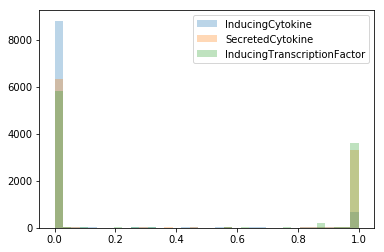

In [3]:
%matplotlib inline
for c in res_train:
    plt.hist(res_train[c][2], bins=36, label=c, alpha=.3)
    plt.legend()

In [4]:
from snorkel.annotations import save_marginals

# Fetch the candidates for each class into a SINGLE list and do
# the same for the marginal arrays since the `save_marginals` function
# deletes all records (with no arguments for filters to avoid this) each time,
# making it impossible to call separately for each set of candidates
candidates, marginals = [], []
for c in res_train:
    X, y = res_train[c][1], res_train[c][2]
    candidates.extend([X.get_candidate(session, i) for i in range(X.shape[0])])
    marginals.append(y)
marginals = np.concatenate(marginals)
assert len(candidates) == len(marginals)
save_marginals(session, candidates, marginals)

Saved 30000 marginals


In [5]:
from snorkel.models import Marginal, Candidate

# Determine the candidate types for all saved marginals
cids = [m.candidate_id for m in session.query(Marginal).all()]
pd.DataFrame(
    session.query(Candidate.id, Candidate.type).filter(Candidate.id.in_(cids)),
    columns=['id', 'type']
).groupby('type').size()

type
inducing_cytokine                10000
inducing_transcription_factor    10000
secreted_cytokine                10000
dtype: int64

In [6]:
def display_statistics(split, candidate_class):
    print('{} (split = {} [{}]):'.format(candidate_class.name, split, SPLIT_MAP[split]))
    X = labeling.get_labels_matrix(session, candidate_class, split)
    y = supervision.get_gold_labels(session, candidate_class, split)
    model = res_train[candidate_class.name][0]
    model.error_analysis(session, X, y.values)
    df = X.lf_stats(session, y.values, model.learned_lf_stats()['Accuracy'])
    display(df.style.background_gradient(subset=['Empirical Acc.', 'Learned Acc.']))
    return df

In [10]:
res_stats = collections.defaultdict(lambda: {})
for split in [SPLIT_VAL, SPLIT_TEST]:
    for c in classes:
        candidate_class = classes[c]
        res_stats[c][split] = display_statistics(split, candidate_class)

InducingCytokine (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.643
Neg. class accuracy: 0.926
Precision            0.391
Recall               0.643
F1                   0.486
----------------------------------------
TP: 9 | FP: 14 | TN: 175 | FN: 5



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.0147783,0.0147783,0.00985222,1,0,0,2,1,0.153846
LF_indck_comp_neg_sec,1,0.142857,0.142857,0.142857,0,0,4,25,0.862069,0.689764
LF_indck_comp_xor,2,0.172414,0.172414,0.172414,2,4,4,25,0.771429,0.711637
LF_indck_dsup_imexpresso_mp04,3,0.236453,0.236453,0.231527,5,9,0,34,0.8125,0.657751
LF_indck_dsup_imexpresso_mp08,4,0.167488,0.167488,0.152709,1,2,0,31,0.941176,0.627258
LF_indck_dsup_imexpresso_mp12,5,0.142857,0.142857,0.128079,1,1,0,27,0.965517,0.566355
LF_indck_dsup_imexpresso_mp20,6,0.08867,0.08867,0.0738916,1,1,0,16,0.944444,0.539711
LF_indck_heur_closer_ck_to_ct,7,0.231527,0.231527,0.162562,0,0,0,47,1,0.818727
LF_indck_heur_closer_ct_to_ck,8,0.20197,0.20197,0.162562,0,0,0,41,1,0.742125
LF_indck_heur_closer_ref,9,0.334975,0.334975,0.26601,0,0,0,68,1,0.846305


SecretedCytokine (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.861
Neg. class accuracy: 0.74
Precision            0.413
Recall               0.861
F1                   0.559
----------------------------------------
TP: 31 | FP: 44 | TN: 125 | FN: 5



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.0292683,0.0292683,0.0292683,5,0,0,1,1,0.3
LF_secck_comp_neg_ind,1,0.0243902,0.0243902,0.0243902,0,0,0,5,1,0.356688
LF_secck_comp_xor,2,0.180488,0.180488,0.180488,15,17,0,5,0.540541,0.702017
LF_secck_dsup_imexpresso_mp04,3,0.253659,0.253659,0.24878,18,18,1,15,0.634615,0.638344
LF_secck_dsup_imexpresso_mp08,4,0.160976,0.160976,0.160976,14,16,0,3,0.515152,0.552533
LF_secck_dsup_imexpresso_mp12,5,0.126829,0.126829,0.126829,9,15,0,2,0.423077,0.531973
LF_secck_dsup_imexpresso_mp20,6,0.097561,0.097561,0.097561,5,13,0,2,0.35,0.435511
LF_secck_heur_closer_ck_to_ct,7,0.24878,0.24878,0.195122,0,0,4,47,0.921569,0.779509
LF_secck_heur_closer_ct_to_ck,8,0.219512,0.219512,0.2,0,0,3,42,0.933333,0.745806
LF_secck_heur_closer_ref,9,0.360976,0.360976,0.307317,0,0,7,67,0.905405,0.826724


InducingTranscriptionFactor (split = 3 [val]):
Scores (Un-adjusted)
Pos. class accuracy: 0.714
Neg. class accuracy: 0.684
Precision            0.312
Recall               0.714
F1                   0.435
----------------------------------------
TP: 25 | FP: 55 | TN: 119 | FN: 10



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.818182,0.818182,0.789474,3,3,18,147,0.877193,0.807506
LF_indtf_heur_closer_ct_to_tf,1,0.148325,0.148325,0.138756,0,0,3,28,0.903226,0.765759
LF_indtf_heur_closer_ref,2,0.258373,0.258373,0.239234,0,0,6,48,0.888889,0.801311
LF_indtf_heur_closer_tf_to_ct,3,0.138756,0.138756,0.119617,0,0,3,26,0.896552,0.736428
LF_indtf_heur_complex_cand_01,4,0.870813,0.870813,0.842105,0,0,29,153,0.840659,0.720521
LF_indtf_heur_complex_cand_02,5,0.521531,0.521531,0.492823,0,0,16,93,0.853211,0.795201
LF_indtf_heur_distref,6,0.172249,0.172249,0.143541,0,0,2,34,0.944444,0.797555
LF_indtf_heur_distref_10,7,1,1,0.971292,24,73,11,101,0.598086,0.84434
LF_indtf_heur_distref_15,8,1,1,0.971292,28,104,7,70,0.4689,0.730352
LF_indtf_heur_distref_20,9,1,1,0.971292,30,121,5,53,0.397129,0.65101


InducingCytokine (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.68
Neg. class accuracy: 0.951
Precision            0.586
Recall               0.68
F1                   0.63
----------------------------------------
TP: 17 | FP: 12 | TN: 234 | FN: 8



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indck_comp_imexpresso_nonneg,0,0.0110701,0.0110701,0.0110701,0,0,0,3,1,0.176471
LF_indck_comp_neg_sec,1,0.151292,0.151292,0.151292,0,0,1,40,0.97561,0.669826
LF_indck_comp_xor,2,0.188192,0.188192,0.188192,7,3,0,41,0.941176,0.713255
LF_indck_dsup_imexpresso_mp04,3,0.236162,0.236162,0.225092,8,9,1,46,0.84375,0.646126
LF_indck_dsup_imexpresso_mp08,4,0.151292,0.151292,0.140221,4,5,0,32,0.878049,0.636741
LF_indck_dsup_imexpresso_mp12,5,0.132841,0.132841,0.121771,4,4,0,28,0.888889,0.573171
LF_indck_dsup_imexpresso_mp20,6,0.118081,0.118081,0.110701,4,4,2,22,0.8125,0.560976
LF_indck_heur_closer_ck_to_ct,7,0.221402,0.221402,0.173432,0,0,1,59,0.983333,0.818268
LF_indck_heur_closer_ct_to_ck,8,0.173432,0.173432,0.136531,0,0,1,46,0.978723,0.721371
LF_indck_heur_closer_ref,9,0.298893,0.298893,0.247232,0,0,2,79,0.975309,0.852036


SecretedCytokine (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.9
Neg. class accuracy: 0.714
Precision            0.413
Recall               0.9
F1                   0.566
----------------------------------------
TP: 45 | FP: 64 | TN: 160 | FN: 5



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_secck_comp_imexpresso_nonneg,0,0.0291971,0.0291971,0.0255474,4,3,0,1,0.625,0.206897
LF_secck_comp_neg_ind,1,0.0328467,0.0328467,0.0328467,0,0,0,9,1,0.280576
LF_secck_comp_xor,2,0.186131,0.186131,0.182482,25,18,0,8,0.647059,0.694079
LF_secck_dsup_imexpresso_mp04,3,0.277372,0.277372,0.270073,12,35,1,28,0.526316,0.63252
LF_secck_dsup_imexpresso_mp08,4,0.145985,0.145985,0.142336,7,23,0,10,0.425,0.578411
LF_secck_dsup_imexpresso_mp12,5,0.135036,0.135036,0.131387,5,22,0,10,0.405405,0.521986
LF_secck_dsup_imexpresso_mp20,6,0.116788,0.116788,0.113139,9,13,0,10,0.59375,0.419878
LF_secck_heur_closer_ck_to_ct,7,0.237226,0.237226,0.20438,0,0,3,62,0.953846,0.772203
LF_secck_heur_closer_ct_to_ck,8,0.160584,0.160584,0.138686,0,0,1,43,0.977273,0.736807
LF_secck_heur_closer_ref,9,0.310219,0.310219,0.270073,0,0,4,81,0.952941,0.80291


InducingTranscriptionFactor (split = 2 [test]):
Scores (Un-adjusted)
Pos. class accuracy: 0.684
Neg. class accuracy: 0.665
Precision            0.342
Recall               0.684
F1                   0.456
----------------------------------------
TP: 39 | FP: 75 | TN: 149 | FN: 18



,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_indtf_comp_xor,0,0.775801,0.775801,0.758007,5,7,34,172,0.811927,0.818347
LF_indtf_heur_closer_ct_to_tf,1,0.163701,0.163701,0.149466,0,0,5,41,0.891304,0.7152
LF_indtf_heur_closer_ref,2,0.241993,0.241993,0.224199,0,0,11,57,0.838235,0.79295
LF_indtf_heur_closer_tf_to_ct,3,0.124555,0.124555,0.113879,0,0,6,29,0.828571,0.707706
LF_indtf_heur_complex_cand_01,4,0.875445,0.875445,0.857651,0,0,48,198,0.804878,0.736012
LF_indtf_heur_complex_cand_02,5,0.52669,0.52669,0.508897,0,0,29,119,0.804054,0.795474
LF_indtf_heur_distref,6,0.149466,0.149466,0.131673,0,0,3,39,0.928571,0.752256
LF_indtf_heur_distref_10,7,1,1,0.982206,37,108,20,116,0.544484,0.84864
LF_indtf_heur_distref_15,8,1,1,0.982206,42,149,15,75,0.41637,0.721681
LF_indtf_heur_distref_20,9,1,1,0.982206,49,171,8,53,0.362989,0.639939
